In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed

class Rectangle:
    def __init__(self, width, height, value):
        self.width = width
        self.height = height
        self.value = value

class Solution:
    def __init__(self, circle_radius):
        self.circle_radius = circle_radius
        self.rectangles = []
        self.positions = []
        self.total_value = 0

    def add_rectangle(self, rectangle, position):
        if self.is_valid_position(rectangle, position):
            self.rectangles.append(rectangle)
            self.positions.append(position)
            self.total_value += rectangle.value

    def is_valid_position(self, rectangle, position):
        x, y = position
        corners = [
            (x, y),
            (x + rectangle.width, y),
            (x, y + rectangle.height),
            (x + rectangle.width, y + rectangle.height)
        ]
        if any(cx**2 + cy**2 > self.circle_radius**2 for cx, cy in corners):
            return False
        for i, rect in enumerate(self.rectangles):
            rx, ry = self.positions[i]
            if not (x + rectangle.width <= rx or x >= rx + rect.width or
                    y + rectangle.height <= ry or y >= ry + rect.height):
                return False
        return True

class GeneticAlgorithm:
    def __init__(self, data, circle_radius, population_size=50, generations=100, mutation_rate=0.2):
        self.rectangles = [Rectangle(row.width, row.height, row.value) for _, row in data.iterrows()]
        self.circle_radius = circle_radius
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

    # Inicjalizuje populację losowymi rozwiazaniami
    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            solution = Solution(self.circle_radius)
            for rectangle in sorted(self.rectangles, key=lambda rect: rect.value, reverse=True):
                for _ in range(100):
                    x, y = random.uniform(-self.circle_radius, self.circle_radius - rectangle.width), random.uniform(-self.circle_radius, self.circle_radius - rectangle.height)
                    if solution.is_valid_position(rectangle, (x, y)):
                        solution.add_rectangle(rectangle, (x, y))
                        break
            population.append(solution)
        return population

    # Szuka losowej pozycji w okregu, w której można umiescic prostokat
    def generate_valid_position(self, rectangle):
        for _ in range(100): 
            x = random.uniform(-self.circle_radius, self.circle_radius - rectangle.width)
            y = random.uniform(-self.circle_radius, self.circle_radius - rectangle.height)
            if self.is_within_circle(x, y, rectangle):
                return (x, y)
        return (0, 0) 

    # Sprawdza, czy prostokat o podanej pozycji jest wewnatrz okregu
    def is_within_circle(self, x, y, rectangle):
        corners = [
            (x, y),
            (x + rectangle.width, y),
            (x, y + rectangle.height),
            (x + rectangle.width, y + rectangle.height)
        ]
        for cx, cy in corners:
            if cx**2 + cy**2 > self.circle_radius**2:
                return False
        return True

    # Funkcja fitness, która zwraca wartosc rozwiazania
    def fitness(self, solution):
        return solution.total_value

    # Selekcja najlepszych rozwiazan
    def selection(self):
        sorted_population = sorted(self.population, key=self.fitness, reverse=True)
        return sorted_population[:self.population_size // 2]

    # Krzyżowanie dwóch rodziców
    def crossover(self, parent1, parent2):
        child = Solution(self.circle_radius)
        for i in range(max(len(parent1.rectangles), len(parent2.rectangles))):
            if i < len(parent1.rectangles) and random.random() < 0.5 and child.is_valid_position(parent1.rectangles[i], parent1.positions[i]):
                child.add_rectangle(parent1.rectangles[i], parent1.positions[i])
            elif i < len(parent2.rectangles) and child.is_valid_position(parent2.rectangles[i], parent2.positions[i]):
                child.add_rectangle(parent2.rectangles[i], parent2.positions[i])
        return child

    # Mutacja rozwiazania
    def mutate(self, solution):
        for i in range(len(solution.rectangles)):
            if random.random() < self.mutation_rate:
                if random.random() < 0.5:  # 50% szans, ze dany prostokat bedzie mutowany
                    for _ in range(10):  # Probuje 10 razy losowo przerzucic dany prostokat na inna pozycje
                        x, y = self.generate_valid_position(solution.rectangles[i])
                        if solution.is_valid_position(solution.rectangles[i], (x, y)):
                            solution.positions[i] = (x, y)
                            break
                else:  # 50% na dodanie nowego prostokata w losowe miejsce
                    rectangle = random.choice(self.rectangles)
                    for _ in range(10):
                        x, y = self.generate_valid_position(rectangle)
                        if solution.is_valid_position(rectangle, (x, y)):
                            solution.add_rectangle(rectangle, (x, y))
                            break

    # Uruchamia algorytm genetyczny
    def run(self):
        best_solution = None
        best_solution_value = 0

        for generation in range(self.generations):
            selected_population = self.selection()
            new_population = selected_population.copy()
            
            while len(new_population) < self.population_size:
                parent1 = random.choice(selected_population)
                parent2 = random.choice(selected_population)
                child = self.crossover(parent1, parent2)
                self.mutate(child)
                new_population.append(child)
            
            self.population = new_population

            # Liczy wartosci fitness dla każdego rozwiazania w populacji
            fitness_values = Parallel(n_jobs=-1)(delayed(self.fitness)(sol) for sol in self.population)
            best_solution_index = np.argmax(fitness_values)
            current_best_solution = self.population[best_solution_index]

            if current_best_solution.total_value > best_solution_value:
                best_solution = current_best_solution
                best_solution_value = current_best_solution.total_value

            # Zwraca wartosc najlepszego rozwiazania w danej generacji
            print(f'Generation {generation}, Best Solution Value: {best_solution_value}')

            # Zmniejsza szanse mutacji wraz z kolejnymi generacjami
            if generation > 0 and generation % 100 == 0:
                self.mutation_rate *= 0.8
        
        # Wizualizacja najlepszego rozwiazania
        self.visualize(best_solution)
        return best_solution

    def visualize(self, solution):
        fig, ax = plt.subplots()
        circle = plt.Circle((0, 0), self.circle_radius, color='r', fill=False)
        ax.add_artist(circle)
        
        for rect, (x, y) in zip(solution.rectangles, solution.positions):
            if self.is_within_circle(x, y, rect):
                ax.add_patch(plt.Rectangle((x, y), rect.width, rect.height, fill=True, edgecolor='b', facecolor='b', alpha=0.5))
                print(f'Rectangle at ({x}, {y}) with width {rect.width} and height {rect.height}')
        
        ax.set_xlim(-self.circle_radius, self.circle_radius)
        ax.set_ylim(-self.circle_radius, self.circle_radius)
        ax.set_aspect('equal', 'box')
        plt.title(f"Total Value: {solution.total_value}")
        plt.show()


In [70]:
# Załadowanie plików
file_paths = ["../data/r800.csv", "../data/r850.csv", "../data/r1000.csv", "../data/r1100.csv", "../data/r1200.csv"]
data = {int(file_path.split('/')[-1].split('.')[0][1:]): pd.read_csv(file_path, header=None, names=['width', 'height', 'value']) for file_path in file_paths}

Running Genetic Algorithm for circle radius 800
Generation 0, Best Solution Value: 2240
Generation 1, Best Solution Value: 2840
Generation 2, Best Solution Value: 3540
Generation 3, Best Solution Value: 3840
Generation 4, Best Solution Value: 4440
Generation 5, Best Solution Value: 4740
Generation 6, Best Solution Value: 5040
Generation 7, Best Solution Value: 5600
Generation 8, Best Solution Value: 6640
Generation 9, Best Solution Value: 6640
Generation 10, Best Solution Value: 7180
Generation 11, Best Solution Value: 7180
Generation 12, Best Solution Value: 8240
Generation 13, Best Solution Value: 10140
Generation 14, Best Solution Value: 10140
Generation 15, Best Solution Value: 10140
Generation 16, Best Solution Value: 10140
Generation 17, Best Solution Value: 10140
Generation 18, Best Solution Value: 10140
Generation 19, Best Solution Value: 10140
Generation 20, Best Solution Value: 10140
Generation 21, Best Solution Value: 10140
Generation 22, Best Solution Value: 10320
Generatio

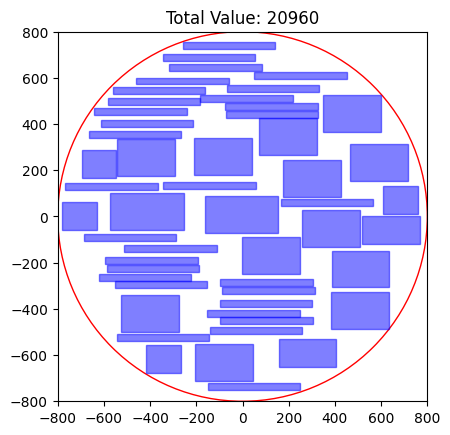

Running Genetic Algorithm for circle radius 850
Generation 0, Best Solution Value: 26770
Generation 1, Best Solution Value: 38970
Generation 2, Best Solution Value: 40170
Generation 3, Best Solution Value: 50120
Generation 4, Best Solution Value: 64810
Generation 5, Best Solution Value: 64810
Generation 6, Best Solution Value: 66190
Generation 7, Best Solution Value: 80010
Generation 8, Best Solution Value: 88040
Generation 9, Best Solution Value: 88040
Generation 10, Best Solution Value: 99190
Generation 11, Best Solution Value: 107790
Generation 12, Best Solution Value: 107790
Generation 13, Best Solution Value: 115470
Generation 14, Best Solution Value: 128030
Generation 15, Best Solution Value: 138880
Generation 16, Best Solution Value: 138880
Generation 17, Best Solution Value: 153840
Generation 18, Best Solution Value: 153840
Generation 19, Best Solution Value: 153840
Generation 20, Best Solution Value: 166160
Generation 21, Best Solution Value: 166160
Generation 22, Best Solutio

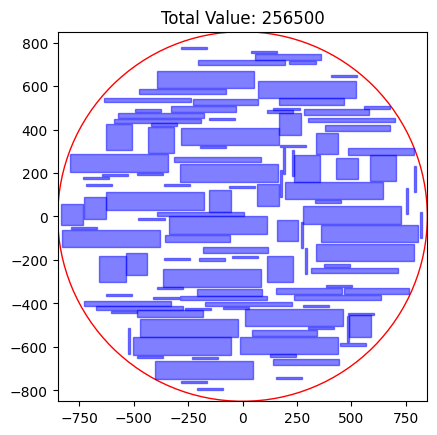

Running Genetic Algorithm for circle radius 1000
Generation 0, Best Solution Value: 1580
Generation 1, Best Solution Value: 1880
Generation 2, Best Solution Value: 1880
Generation 3, Best Solution Value: 2240
Generation 4, Best Solution Value: 3240
Generation 5, Best Solution Value: 3240
Generation 6, Best Solution Value: 3540
Generation 7, Best Solution Value: 4120
Generation 8, Best Solution Value: 4840
Generation 9, Best Solution Value: 5460
Generation 10, Best Solution Value: 5580
Generation 11, Best Solution Value: 6840
Generation 12, Best Solution Value: 7180
Generation 13, Best Solution Value: 7580
Generation 14, Best Solution Value: 7640
Generation 15, Best Solution Value: 8040
Generation 16, Best Solution Value: 8580
Generation 17, Best Solution Value: 9900
Generation 18, Best Solution Value: 9900
Generation 19, Best Solution Value: 10080
Generation 20, Best Solution Value: 10080
Generation 21, Best Solution Value: 10620
Generation 22, Best Solution Value: 10620
Generation 23,

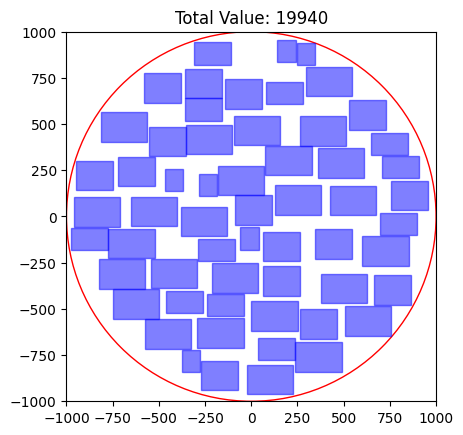

Running Genetic Algorithm for circle radius 1100
Generation 0, Best Solution Value: 1640
Generation 1, Best Solution Value: 2240
Generation 2, Best Solution Value: 2240
Generation 3, Best Solution Value: 2240
Generation 4, Best Solution Value: 2440
Generation 5, Best Solution Value: 2840
Generation 6, Best Solution Value: 3280
Generation 7, Best Solution Value: 3880
Generation 8, Best Solution Value: 5180
Generation 9, Best Solution Value: 5180
Generation 10, Best Solution Value: 5340
Generation 11, Best Solution Value: 5880
Generation 12, Best Solution Value: 7140
Generation 13, Best Solution Value: 7280
Generation 14, Best Solution Value: 8360
Generation 15, Best Solution Value: 8840
Generation 16, Best Solution Value: 8900
Generation 17, Best Solution Value: 10180
Generation 18, Best Solution Value: 10880
Generation 19, Best Solution Value: 11820
Generation 20, Best Solution Value: 11820
Generation 21, Best Solution Value: 11820
Generation 22, Best Solution Value: 12220
Generation 2

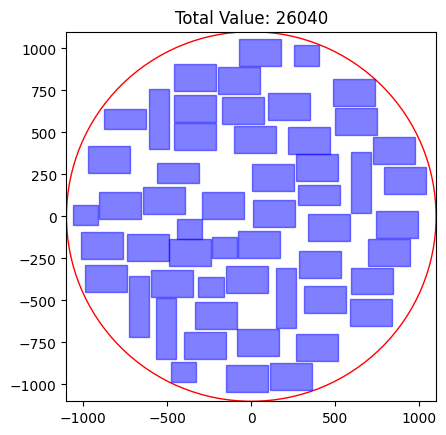

Running Genetic Algorithm for circle radius 1200
Generation 0, Best Solution Value: 1740
Generation 1, Best Solution Value: 2040
Generation 2, Best Solution Value: 2180
Generation 3, Best Solution Value: 2740
Generation 4, Best Solution Value: 2940
Generation 5, Best Solution Value: 3240
Generation 6, Best Solution Value: 3480
Generation 7, Best Solution Value: 4040
Generation 8, Best Solution Value: 4380
Generation 9, Best Solution Value: 5540
Generation 10, Best Solution Value: 6680
Generation 11, Best Solution Value: 6680
Generation 12, Best Solution Value: 7140
Generation 13, Best Solution Value: 7420
Generation 14, Best Solution Value: 7980
Generation 15, Best Solution Value: 8100
Generation 16, Best Solution Value: 9040
Generation 17, Best Solution Value: 9620
Generation 18, Best Solution Value: 10260
Generation 19, Best Solution Value: 11260
Generation 20, Best Solution Value: 11680
Generation 21, Best Solution Value: 13320
Generation 22, Best Solution Value: 13660
Generation 23

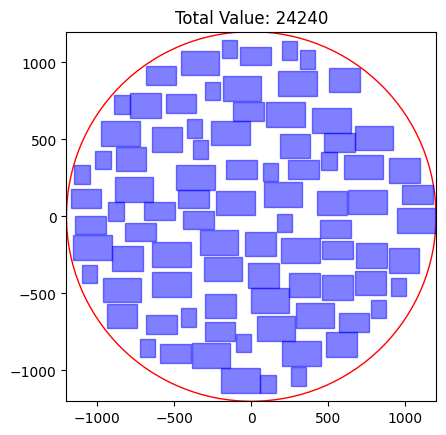

In [71]:
results = {}
for radius in [800, 850, 1000, 1100, 1200]:
    print(f'Running Genetic Algorithm for circle radius {radius}')
    ga = GeneticAlgorithm(data[radius], radius, generations=100)
    best_solution = ga.run()
    results[radius] = best_solution.total_value

In [67]:
min_values = {800: 30000, 850: 0, 1000: 17500, 1100: 25000, 1200: 30000}

In [68]:
# Display results
for radius, value in results.items():
    # Check if the value meets the minimum requirement
    if value >= min_values[radius]:
        status = 'OK'
    else:
        status = 'Not OK'
    print(f'Circle Radius: {radius}, Best Solution Value: {value}, Status: {status}')

Circle Radius: 800, Best Solution Value: 24520, Status: Not OK
Circle Radius: 850, Best Solution Value: 362330, Status: OK
Circle Radius: 1000, Best Solution Value: 18720, Status: OK
Circle Radius: 1100, Best Solution Value: 25680, Status: OK
Circle Radius: 1200, Best Solution Value: 26700, Status: Not OK
